In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


In [2]:
# Column names as per CMAPSS documentation
columns = (
    ['unit_id', 'cycle'] +
    [f'op_setting_{i}' for i in range(1, 4)] +
    [f'sensor_{i}' for i in range(1, 22)]
)


In [3]:
# Load training data
train_path = "/content/train_FD001.txt"
train_df = pd.read_csv(
    train_path,
    sep=" ",
    header=None
)

# Remove empty last columns
train_df = train_df.iloc[:, :-2]
train_df.columns = columns

train_df.head()


,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
print("Shape:", train_df.shape)
print("Unique machines:", train_df['unit_id'].nunique())
print("Max cycles:", train_df['cycle'].max())


Shape: (20631, 26)
Unique machines: 100
Max cycles: 362


In [5]:
# Compute RUL
max_cycles = train_df.groupby('unit_id')['cycle'].max().reset_index()
max_cycles.columns = ['unit_id', 'max_cycle']

train_df = train_df.merge(max_cycles, on='unit_id')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

train_df.drop(columns=['max_cycle'], inplace=True)
train_df.head()


,unit_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


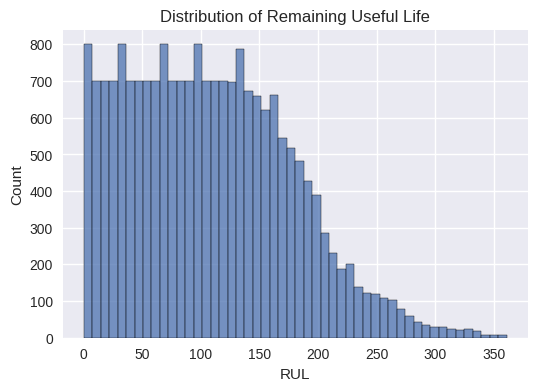

In [6]:
plt.figure(figsize=(6,4))
sns.histplot(train_df['RUL'], bins=50)
plt.title("Distribution of Remaining Useful Life")
plt.show()


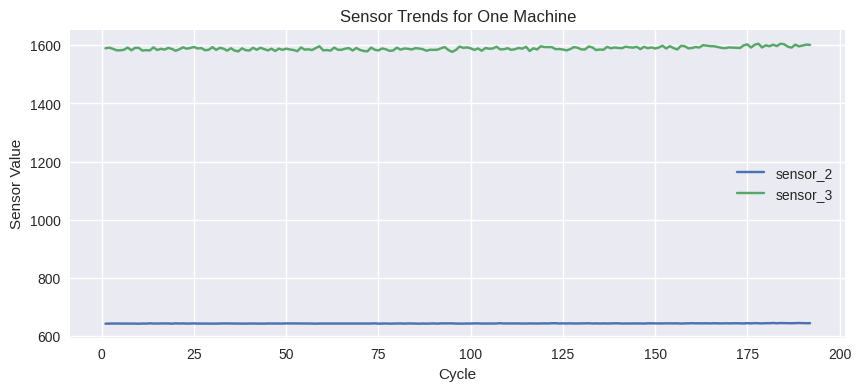

In [7]:
unit_example = 1
subset = train_df[train_df['unit_id'] == unit_example]

plt.figure(figsize=(10,4))
plt.plot(subset['cycle'], subset['sensor_2'], label='sensor_2')
plt.plot(subset['cycle'], subset['sensor_3'], label='sensor_3')
plt.xlabel("Cycle")
plt.ylabel("Sensor Value")
plt.title("Sensor Trends for One Machine")
plt.legend()
plt.show()


In [8]:
# Drop non-informative sensors (based on CMAPSS literature)
drop_sensors = [
    'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10',
    'sensor_16', 'sensor_18', 'sensor_19'
]

features = [c for c in train_df.columns if c not in drop_sensors + ['unit_id', 'cycle', 'RUL']]


In [9]:
from sklearn.model_selection import train_test_split

unit_ids = train_df['unit_id'].unique()

train_units, val_units = train_test_split(
    unit_ids, test_size=0.2, random_state=42
)

train_data = train_df[train_df['unit_id'].isin(train_units)]
val_data = train_df[train_df['unit_id'].isin(val_units)]


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])


/tmp/ipython-input-3605912451.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[features] = scaler.fit_transform(train_data[features])
/tmp/ipython-input-3605912451.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data[features] = scaler.transform(val_data[features])


In [11]:
def create_windows(df, window_size=30):
    X, y = [], []

    for unit in df['unit_id'].unique():
        unit_df = df[df['unit_id'] == unit]

        for i in range(len(unit_df) - window_size):
            X.append(unit_df[features].iloc[i:i+window_size].values)
            y.append(unit_df['RUL'].iloc[i+window_size])

    return np.array(X), np.array(y)


In [12]:
WINDOW_SIZE = 30

X_train, y_train = create_windows(train_data, WINDOW_SIZE)
X_val, y_val = create_windows(val_data, WINDOW_SIZE)

print(X_train.shape, y_train.shape)


(14161, 30, 17) (14161,)


In [13]:
np.save("/content/X_train.npy", X_train)
np.save("/content/y_train.npy", y_train)
np.save("/content/X_val.npy", X_val)
np.save("/content/y_val.npy", y_val)
